# Phase 2 - Modeling

Baseline and gradient boosted churn models with performance comparison.

## Imports and data loading

In [1]:
from pathlib import Path
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, confusion_matrix

from xgboost import XGBClassifier
import seaborn as sns
import matplotlib.pyplot as plt
import joblib

PROJECT_ROOT = Path.cwd()
if PROJECT_ROOT.name == "notebooks":
    PROJECT_ROOT = PROJECT_ROOT.parent

PROCESSED_PATH = PROJECT_ROOT / "data" / "processed" / "churn_clean.csv"
MODELS_DIR = PROJECT_ROOT / "models"
PREDICTIONS_PATH = PROJECT_ROOT / "data" / "processed" / "churn_predictions.csv"

data = pd.read_csv(PROCESSED_PATH)
data.head()

,customerID,Age,Gender,Tenure,UsageFrequency,SupportCalls,PaymentDelay,TotalSpend,LastInteraction,Churn,dataset,SubscriptionType_Premium,SubscriptionType_Standard,ContractType_Monthly,ContractType_Quarterly
0,2.0,30.0,0.0,39.0,14.0,5.0,18.0,932.0,17.0,1,train,False,True,False,False
1,3.0,65.0,0.0,49.0,1.0,10.0,8.0,557.0,6.0,1,train,False,False,True,False
2,4.0,55.0,0.0,14.0,4.0,6.0,18.0,185.0,3.0,1,train,False,False,False,True
3,5.0,58.0,1.0,38.0,21.0,7.0,7.0,396.0,29.0,1,train,False,True,True,False
4,6.0,23.0,1.0,32.0,20.0,5.0,8.0,617.0,20.0,1,train,False,False,True,False


## Prepare train and validation splits

In [2]:
train_data = data[data["dataset"] == "train"].copy()
holdout_data = data[data["dataset"] == "test"].copy()

FEATURE_DROP = ["customerID", "dataset"]
TARGET = "Churn"

X = train_data.drop(columns=FEATURE_DROP + [TARGET])
y = train_data[TARGET]
feature_names = X.columns.tolist()

X_train, X_valid, y_train, y_valid = train_test_split(
    X,
    y,
    test_size=0.2,
    stratify=y,
    random_state=42
)
X_train.shape, X_valid.shape

((352666, 12), (88167, 12))

## Train models

In [3]:
fitted_models = {}
metrics = []

log_reg = Pipeline(
    steps=[
        ("scaler", StandardScaler()),
        ("model", LogisticRegression(max_iter=1000, class_weight="balanced"))
    ]
)
log_reg.fit(X_train, y_train)
y_pred_lr = log_reg.predict(X_valid)
y_proba_lr = log_reg.predict_proba(X_valid)[:, 1]
metrics.append(
    {
        "model": "Logistic Regression",
        "accuracy": accuracy_score(y_valid, y_pred_lr),
        "roc_auc": roc_auc_score(y_valid, y_proba_lr),
        "f1": f1_score(y_valid, y_pred_lr)
    }
)
fitted_models["Logistic Regression"] = {
    "estimator": log_reg,
    "pred": y_pred_lr,
    "proba": y_proba_lr
}

xgb = XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    n_estimators=300,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.9,
    colsample_bytree=0.9,
    random_state=42,
    reg_lambda=1.0,
    use_label_encoder=False
)
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_valid)
y_proba_xgb = xgb.predict_proba(X_valid)[:, 1]
metrics.append(
    {
        "model": "XGBoost",
        "accuracy": accuracy_score(y_valid, y_pred_xgb),
        "roc_auc": roc_auc_score(y_valid, y_proba_xgb),
        "f1": f1_score(y_valid, y_pred_xgb)
    }
)
fitted_models["XGBoost"] = {
    "estimator": xgb,
    "pred": y_pred_xgb,
    "proba": y_proba_xgb
}

results = pd.DataFrame(metrics).set_index("model")
results

D:\Portfolio Projects\Customer Lifetime Value & Retention Intelligence Platform\.venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [20:11:10] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


,accuracy,roc_auc,f1
model,,,
Logistic Regression,0.894995,0.959057,0.903919
XGBoost,0.998877,0.999998,0.999009


## Confusion matrix for best model

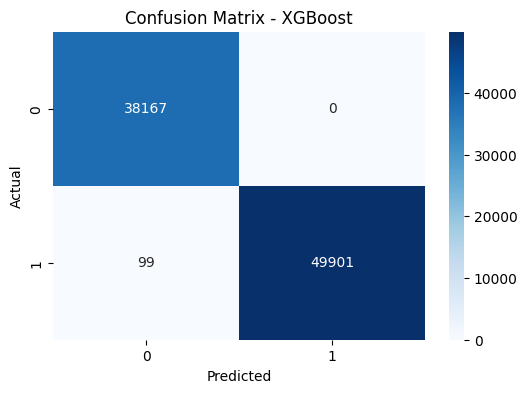

'XGBoost'

In [4]:
best_model_name = results.sort_values("roc_auc", ascending=False).index[0]
best_model = fitted_models[best_model_name]["estimator"]
best_pred = fitted_models[best_model_name]["pred"]

cm = confusion_matrix(y_valid, best_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title(f"Confusion Matrix - {best_model_name}")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
best_model_name

## Feature importances

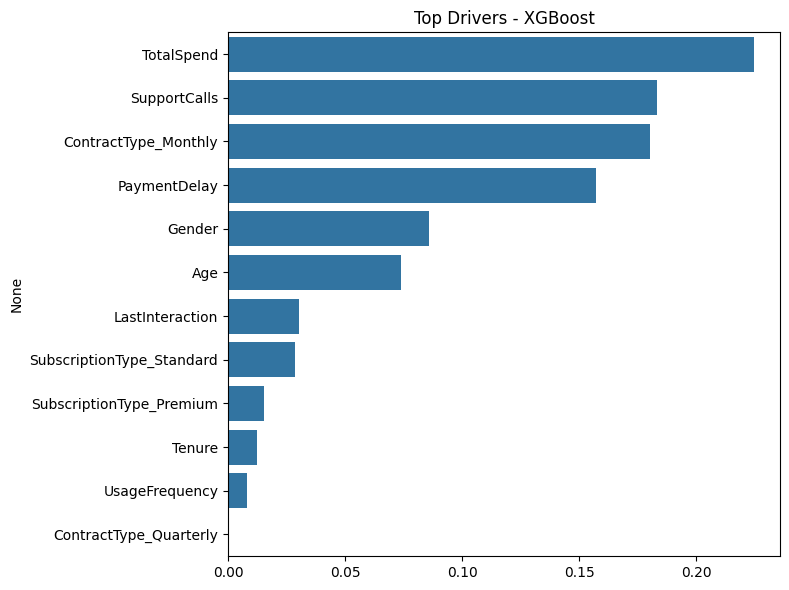

TotalSpend                   0.224576
SupportCalls                 0.183135
ContractType_Monthly         0.180200
PaymentDelay                 0.157164
Gender                       0.085774
Age                          0.073968
LastInteraction              0.030129
SubscriptionType_Standard    0.028822
SubscriptionType_Premium     0.015274
Tenure                       0.012484
UsageFrequency               0.008313
ContractType_Quarterly       0.000162
dtype: float32

In [5]:
if best_model_name == "Logistic Regression":
    coef = best_model.named_steps["model"].coef_[0]
    importance = pd.Series(coef, index=feature_names)
else:
    importance = pd.Series(best_model.feature_importances_, index=feature_names)

top_importance = importance.sort_values(key=lambda x: x.abs(), ascending=False).head(15)
plt.figure(figsize=(8, 6))
sns.barplot(x=top_importance.values, y=top_importance.index)
plt.title(f"Top Drivers - {best_model_name}")
plt.tight_layout()
plt.show()
top_importance

## Persist model and predictions

In [6]:
MODELS_DIR.mkdir(parents=True, exist_ok=True)
model_path = MODELS_DIR / "churn_model.pkl"
joblib.dump(best_model, model_path)

feature_columns = feature_names
inference_features = data[feature_columns].copy()
inference_proba = best_model.predict_proba(inference_features)[:, 1]

predictions = data[["customerID", "dataset"]].copy()
predictions["churn_probability"] = inference_proba
if TARGET in data.columns:
    predictions[TARGET] = data[TARGET]
predictions["churn_prediction"] = (predictions["churn_probability"] >= 0.5).astype(int)
predictions.to_csv(PREDICTIONS_PATH, index=False)

model_path, PREDICTIONS_PATH

(WindowsPath('D:/Portfolio Projects/Customer Lifetime Value & Retention Intelligence Platform/models/churn_model.pkl'),
 WindowsPath('D:/Portfolio Projects/Customer Lifetime Value & Retention Intelligence Platform/data/processed/churn_predictions.csv'))